# Data vs. MC Comparisons for Stubs

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
from os import path
import sys
import uproot
from tqdm import tqdm
from scipy.interpolate import CubicSpline

# local imports
sys.path.append('../../')
from variable_configs import VariableConfig
from analysis_village.numucc1p0pi.selection_definitions import *
from pyanalib.split_df_helpers import *
from pyanalib.stat_helpers import *
from makedf.constants import *

plt.style.use("presentation.mplstyle")
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)

# Utils

In [55]:
# Setup splines to map from Length or Charge to Energy
def dEdx2dQdx(dEdx):
    alpha = 0.930
    rho = 1.38434
    Efield = 0.5
    beta = 0.212 / (rho * Efield)
    Wion = 1e3 / 4.237e7
    return np.log(alpha + dEdx*beta) / (Wion*beta)

def dQdx2dEdx(dQdx):
    alpha = 0.930
    rho = 1.38434
    Efield = 0.5
    beta = 0.212 / (rho * Efield)
    Wion = 1e3 / 4.237e7
    return (np.exp(beta * Wion * dQdx) - alpha) / beta

# Load the pstar data
LAr_density = 1.38434
data = np.genfromtxt('PSTAR.txt',dtype=None).T
KE = data[0, :]
dEdx = data[1,:] * LAr_density
RR = data[2,:] / LAr_density

dQdx = dEdx2dQdx(dEdx)

RR0 = np.hstack([[0.], RR])
integrated_dQ = np.cumsum(dQdx * (RR-RR0[:-1]))

RR_dEdx_spline = CubicSpline(RR, dEdx)
RR_many = np.logspace(np.log10(np.min(RR)), np.log10(np.max(RR)), 1000)
dEdx_many = RR_dEdx_spline(RR_many)
dQdx_many = dEdx2dQdx(dEdx_many)
RR_many_0 = np.hstack([[0.], RR_many])
integrated_dQ_many = np.cumsum(dQdx_many * (RR_many-RR_many_0[:-1]))
KE_many = np.cumsum(dEdx_many * (RR_many-RR_many_0[:-1]))

RRall = RR
dQdxall = dQdx
deltaQdeltaX = integrated_dQ / RRall

where = (KE < 200) & (KE > 10)
KE = KE[where]
integrated_dQ = integrated_dQ[where]
RR = RR[where]

dQdx = dQdx[where]

where_many = (KE_many < 200) & (KE_many > 10)
KE_many = KE_many[where_many]
integrated_dQ_many = integrated_dQ_many[where_many]
RR_many = RR_many[where_many]

max_delta_Q = np.max(integrated_dQ)
min_delta_Q = np.min(integrated_dQ)

def deltaQ2deltaE_with(deltaQ, fitfunc, popt):
    ret = fitfunc(deltaQ, *popt)
    ret[deltaQ < min_delta_Q] = -10000.
    ret[deltaQ > max_delta_Q] =  10000.
    return ret

def deltaQ2deltaE(deltaQ):
    return deltaQ2deltaE_with(deltaQ, Q_spline, [])


In [56]:
range_spline = CubicSpline(RR, KE)
Q_spline = CubicSpline(integrated_dQ, KE)

In [64]:
def dEdx2dQdx(dEdx, Efield=0.5):
    alpha = 0.930
    rho = 1.38434
    #Efield = 0.5
    beta = 0.212 / (rho * Efield)
    Wion = 1e3 / 4.237e7
    return np.log(alpha + dEdx*beta) / (Wion*beta)

MIP_dqdx = dEdx2dQdx(1.7) # dEdx2dQdx(1.8, (stubdf.efield_vtx + stubdf.efield_end) / 2.) * (0.01420 / 1.59e-2)

## Off-beam

- this would kind of be like background calibration

In [2]:
file_dir = "/exp/sbnd/data/users/munjung/xsec/2025B"
mc_file_offbeam = "MC_intime-stubs.df"
data_file_offbeam = "Data_intime-stubs_10000files.df"

mc_file = path.join(file_dir, mc_file_offbeam)
mc_split_df = pd.read_hdf(mc_file, key="split")
mc_n_split = get_n_split(mc_file)
print("mc_n_split: %d" %(mc_n_split))
print_keys(mc_file)

data_file = path.join(file_dir, data_file_offbeam)
data_split_df = pd.read_hdf(data_file, key="split")
data_n_split = get_n_split(data_file)
print("data_n_split: %d" %(data_n_split))
print_keys(data_file)

mc_n_split: 1
Keys: ['/split', '/stubs_0']
data_n_split: 1
Keys: ['/split', '/stubs_0']


In [6]:
n_max_concat = 10
keys2load = ['stubs']

mc_dfs = load_dfs(mc_file, keys2load, n_max_concat=n_max_concat)
mc_offbeam = mc_dfs['stubs']
data_dfs = load_dfs(data_file, keys2load, n_max_concat=n_max_concat)
data_offbeam = data_dfs['stubs']

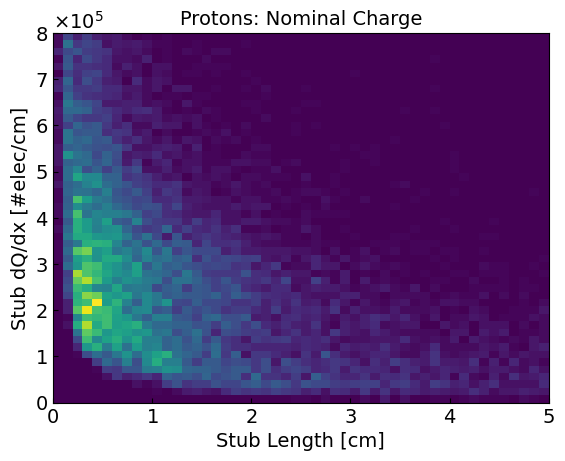

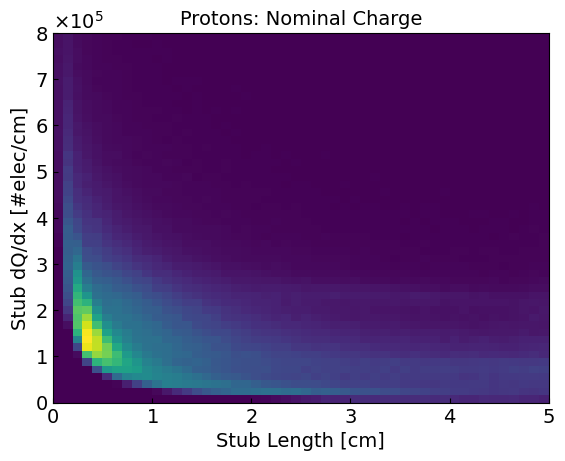

In [19]:
binx = np.linspace(0, 5, 51)
biny = np.linspace(0, 800000, 51)

when = (np.abs(mc_offbeam.truth.p.pdg) == 2212) & (mc_offbeam.truth.p.genE - PROTON_MASS < 0.05) #& (mc_offbeam.nplane == 1)
_ = plt.hist2d(mc_offbeam.length[when], (mc_offbeam.charge / mc_offbeam.length)[when], bins=[binx, biny])
plt.ticklabel_format(axis='y', style='sci', scilimits=(5,5))

plt.xlabel("Stub Length [cm]")
plt.ylabel("Stub dQ/dx [#elec/cm]")
plt.title("Protons: Nominal Charge")
plt.show();

_ = plt.hist2d(data_offbeam.length, (data_offbeam.charge / data_offbeam.length), bins=[binx, biny])
plt.ticklabel_format(axis='y', style='sci', scilimits=(5,5))

plt.xlabel("Stub Length [cm]")
plt.ylabel("Stub dQ/dx [#elec/cm]")
plt.title("Protons: Nominal Charge")
plt.show();

## On-beam

- now for neutrinos

In [21]:
file_dir = "/exp/sbnd/data/users/munjung/xsec/2025B"
mc_file_onbeam = "MC_bnb_cosmics-stubs.df"
data_file_onbeam = "Data_dev-stubs.df"

mc_file = path.join(file_dir, mc_file_onbeam)
mc_split_df = pd.read_hdf(mc_file, key="split")
mc_n_split = get_n_split(mc_file)
print("mc_n_split: %d" %(mc_n_split))
print_keys(mc_file)

data_file = path.join(file_dir, data_file_onbeam)
data_split_df = pd.read_hdf(data_file, key="split")
data_n_split = get_n_split(data_file)
print("data_n_split: %d" %(data_n_split))
print_keys(data_file)

mc_n_split: 3
Keys: ['/bnbpot', '/hdr', '/split', '/stub', '/stubs_0', '/stubs_1', '/stubs_2']
data_n_split: 1
Keys: ['/bnbpot', '/hdr', '/split', '/stub', '/stubs_0']


In [22]:
n_max_concat = 10
keys2load = ['stubs']

mc_dfs = load_dfs(mc_file, keys2load, n_max_concat=n_max_concat)
mc_onbeam = mc_dfs['stubs']
data_dfs = load_dfs(data_file, keys2load, n_max_concat=n_max_concat)
data_onbeam = data_dfs['stubs']

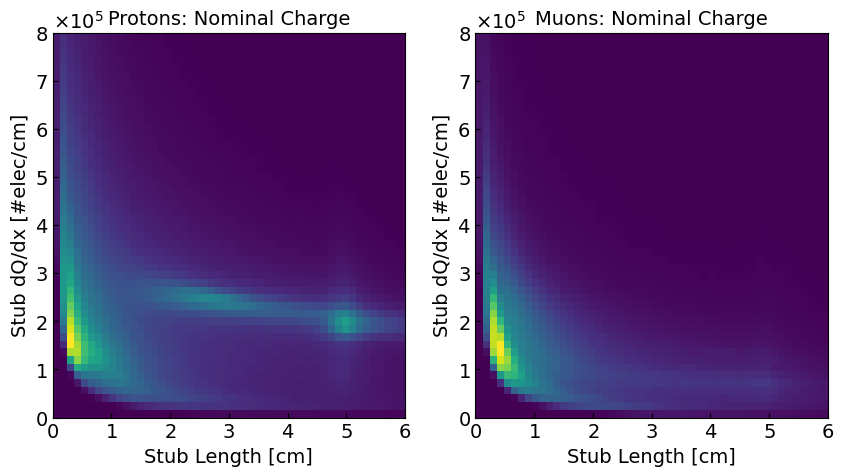

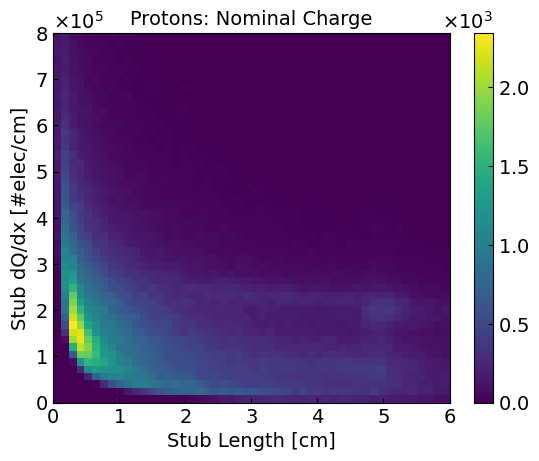

In [116]:
binx = np.linspace(0, 6, 51)
biny = np.linspace(0, 800000, 51)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

when = (np.abs(mc_onbeam.truth.p.pdg) == 2212) # & (mc_onbeam.truth.p.genE - PROTON_MASS < 0.05) #& (mc_onbeam.nplane == 1)
n_mc_protons, xedges, yedges, img = ax[0].hist2d(mc_onbeam.length[when], (mc_onbeam.charge / mc_onbeam.length)[when], bins=[binx, biny])
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(5,5))
ax[0].set_xlabel("Stub Length [cm]")
ax[0].set_ylabel("Stub dQ/dx [#elec/cm]")
ax[0].set_title("Protons: Nominal Charge")

when = (np.abs(mc_onbeam.truth.p.pdg) == 13) & (mc_onbeam.truth.p.genE - MUON_MASS) #& (mc_onbeam.nplane == 1)
n_mc_muons, xedges, yedges, img = ax[1].hist2d(mc_onbeam.length[when], (mc_onbeam.charge / mc_onbeam.length)[when], bins=[binx, biny])
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(5,5))
ax[1].set_xlabel("Stub Length [cm]")
ax[1].set_ylabel("Stub dQ/dx [#elec/cm]")
ax[1].set_title("Muons: Nominal Charge")

plt.show();

n_data_protons, xedges, yedges, img = plt.hist2d(data_onbeam.length, (data_onbeam.charge / data_onbeam.length), bins=[binx, biny])
plt.ticklabel_format(axis='y', style='sci', scilimits=(5,5))
plt.colorbar()
plt.xlabel("Stub Length [cm]")
plt.ylabel("Stub dQ/dx [#elec/cm]")
plt.title("Protons: Nominal Charge")
plt.show();

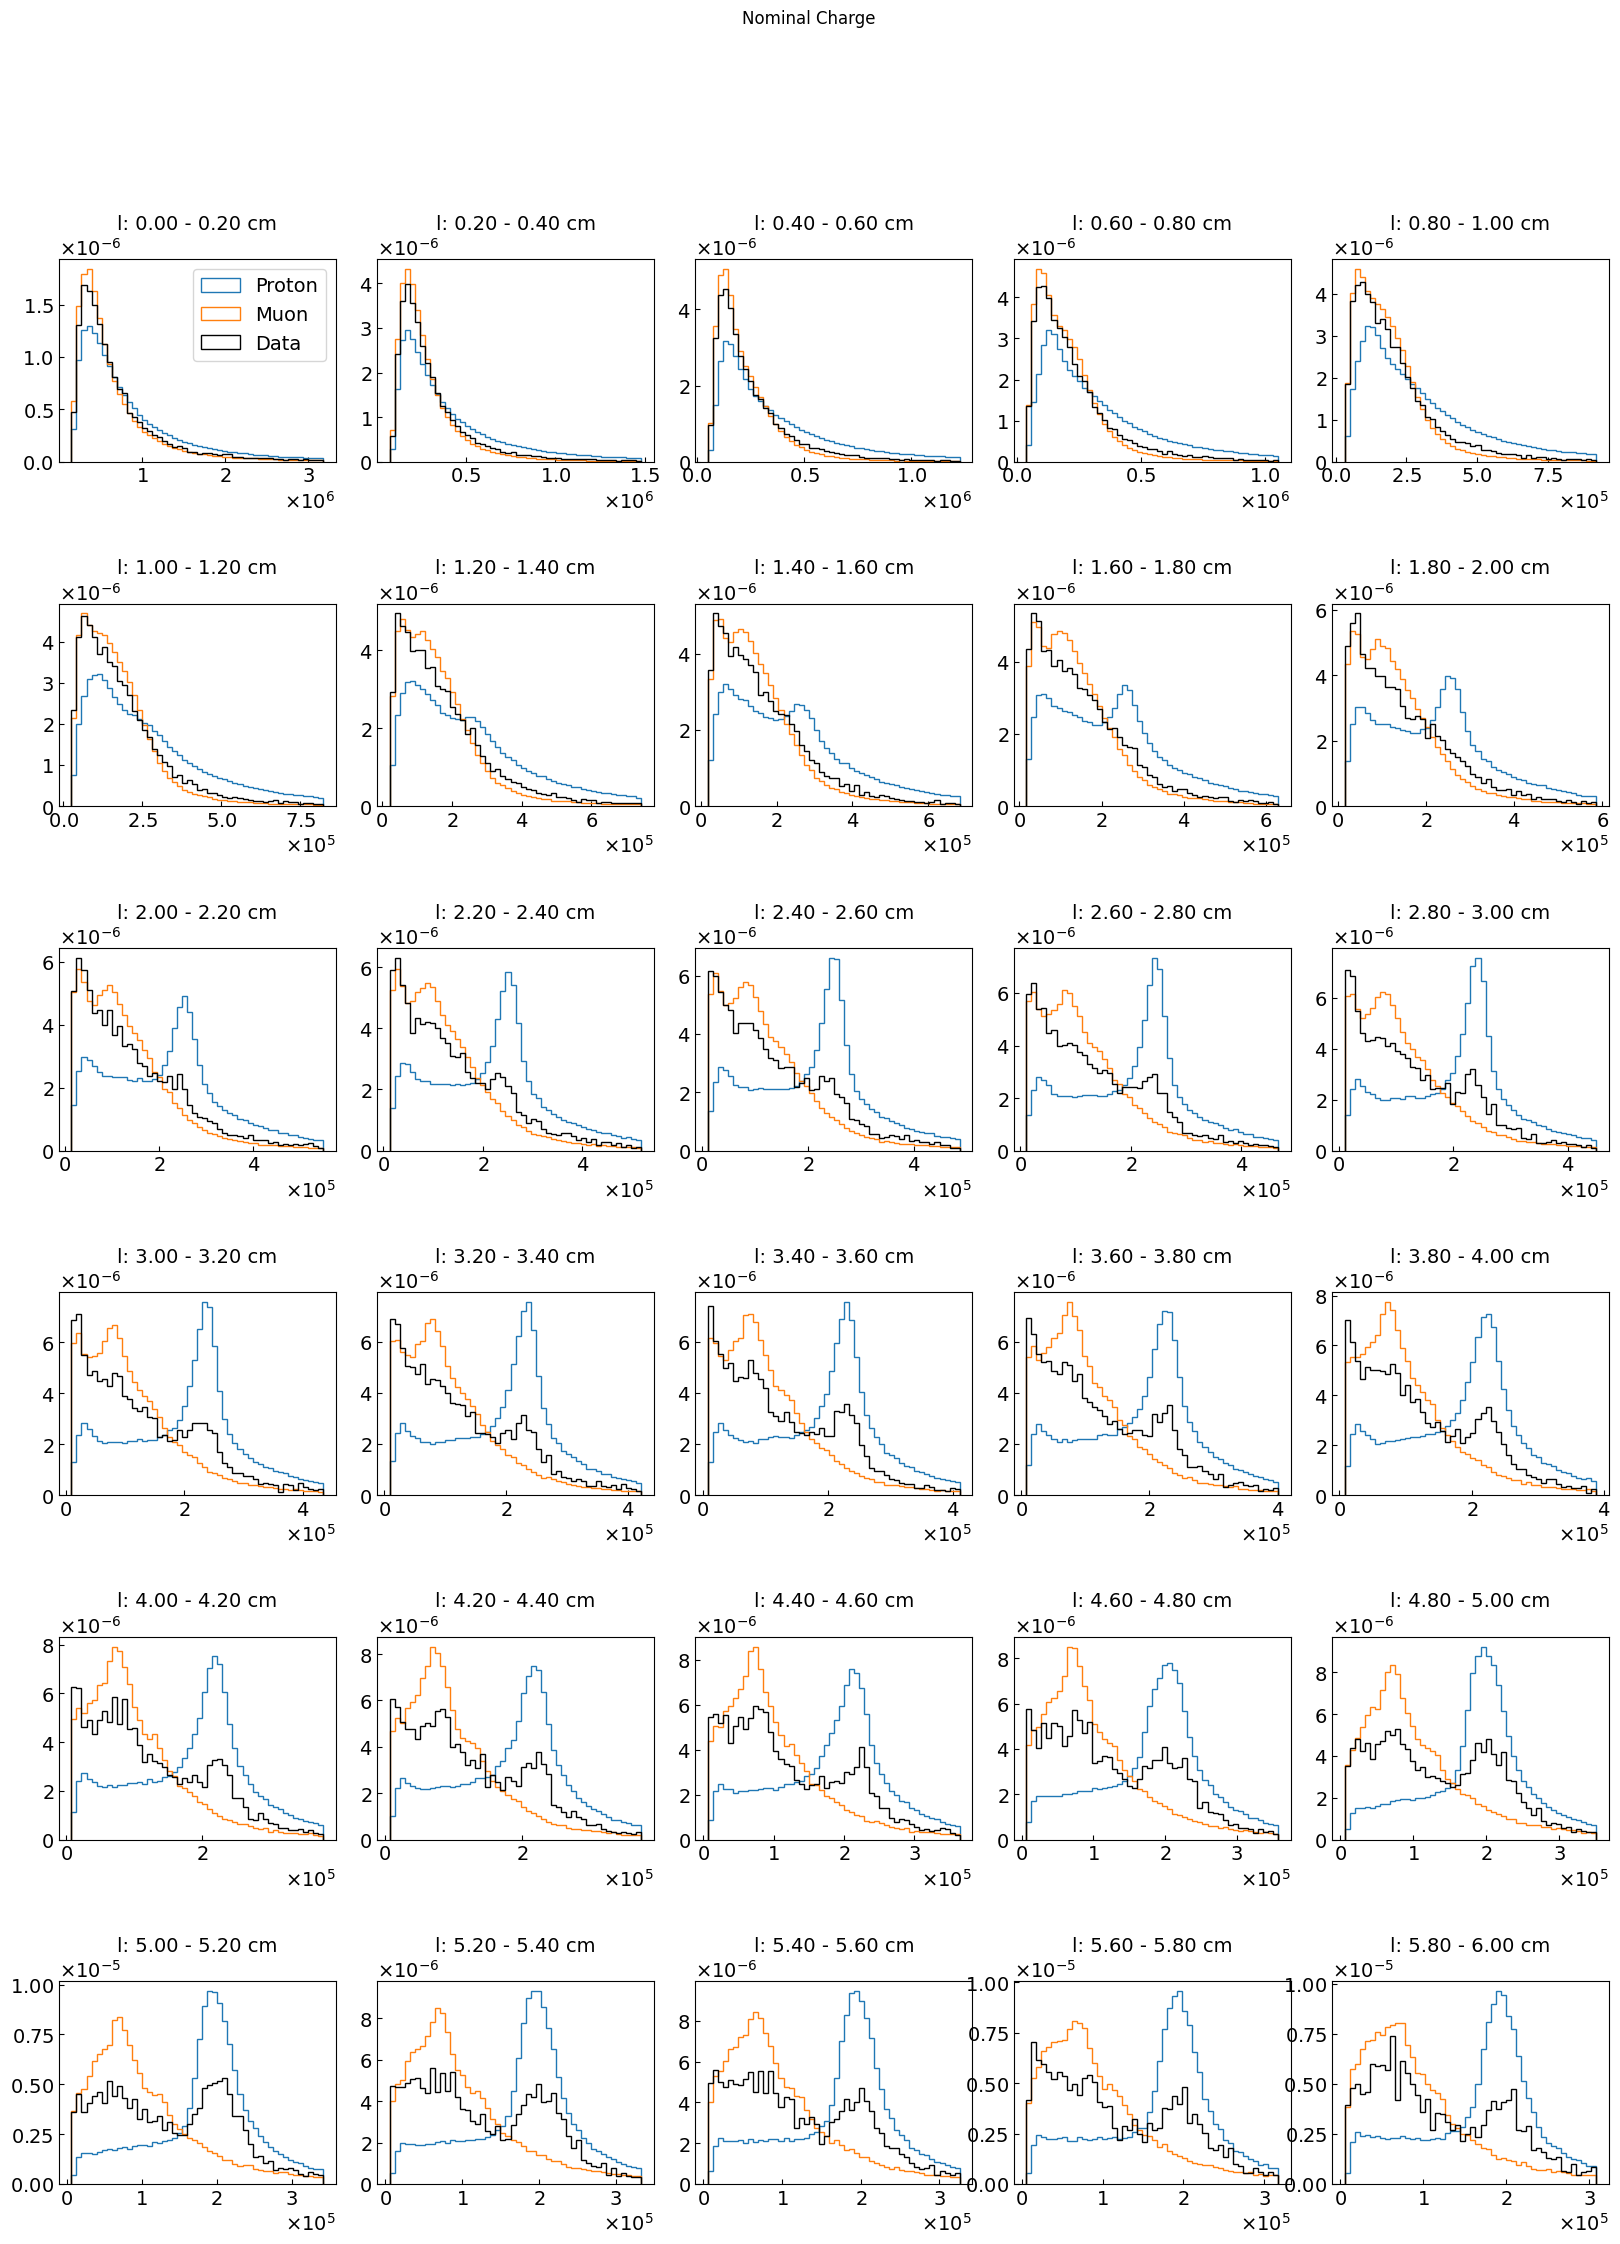

In [119]:
# 1D distributions
binx = np.linspace(0, 6, 31)
biny = np.linspace(0, 800000, 51)

fig, axs = plt.subplots(6, 5, figsize=(20, 25))
fig.subplots_adjust(wspace=0.15, hspace=0.7)
fig.suptitle("Nominal Charge")

for i in range(30):
    ax_x = axs[i//5, i%5]

    when = (np.abs(mc_onbeam.truth.p.pdg) == 2212) & (mc_onbeam.length > binx[i]) & (mc_onbeam.length < binx[i+1])
    this_dqdx = (mc_onbeam.charge / mc_onbeam.length)[when]
    xrange_lo = np.min(this_dqdx)
    xrange_hi = np.max(np.sort(this_dqdx)[:-len(this_dqdx)//20][::-1])
    bins = np.linspace(xrange_lo, xrange_hi, 51)
    ax_x.hist(this_dqdx, bins=bins, histtype='step', label="Proton", density=True)

    when = (np.abs(mc_onbeam.truth.p.pdg) == 13) & (mc_onbeam.length > binx[i]) & (mc_onbeam.length < binx[i+1])
    this_dqdx = (mc_onbeam.charge / mc_onbeam.length)[when]
    bins = np.linspace(xrange_lo, xrange_hi, 51)
    ax_x.hist(this_dqdx, bins=bins, histtype='step', label="Muon", density=True)

    when = (data_onbeam.length > binx[i]) & (data_onbeam.length < binx[i+1])
    this_data_dqdx = (data_onbeam.charge / data_onbeam.length)[when]
    bins = np.linspace(xrange_lo, xrange_hi, 51)
    ax_x.hist(this_data_dqdx, bins=bins, histtype='step', label="Data", color="black", density=True)

    # ax_x.set_ylabel("Stub dQ/dx [#elec/cm]")
    ax_x.set_title("l: %.2f - %.2f cm" %(binx[i], binx[i+1]))

    if i == 0:
        ax_x.legend()
plt.show();

In [ ]:
def plot_dqdx_1d(len_lo, len_hi):
    when = (np.abs(mc_onbeam.truth.p.pdg) == 2212) & (mc_onbeam.length > len_lo) & (mc_onbeam.length < len_hi)
    this_dqdx = (mc_onbeam.charge / mc_onbeam.length)[when]
    xrange_lo = np.min(this_dqdx)
    xrange_hi = np.max(np.sort(this_dqdx)[:-len(this_dqdx)//50][::-1])
    bins = np.linspace(xrange_lo, xrange_hi, 51)
    n_mc, bins, _ = plt.hist(this_dqdx, bins=bins, histtype='step', label="Proton", density=False, linewidth=2)
    ymax_mc = np.max(n_mc)

    when = (data_onbeam.length > len_lo) & (data_onbeam.length < len_hi)
    this_data_dqdx = (data_onbeam.charge / data_onbeam.length)[when]
    n_data, bins = np.histogram(this_data_dqdx, bins=bins)
    ymax_data = np.max(n_data[18:])
    # plt.axvline(bins[18], color="red", linestyle="--")
    bin_centers = (bins[:-1] + bins[1:]) / 2
    ratio = ymax_mc / ymax_data
    # plt.hist(bin_centers, bins=bins, weights=n_data*ratio, histtype='step', label="Data", density=False)
    plt.errorbar(bin_centers, n_data*ratio, yerr=np.sqrt(n_data)*ratio, fmt='o', label="Data", color="black")

    plt.xlabel("Stub dQ/dx [#elec/cm]")
    plt.ylabel("Stubs")
    plt.title("l: %.2f - %.2f cm" %(len_lo, len_hi))
    plt.legend()
    plt.show();

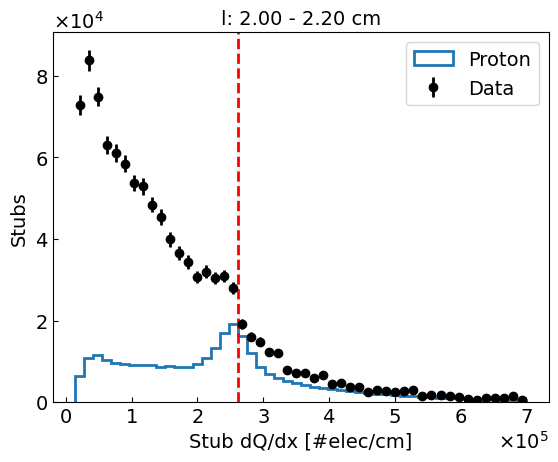

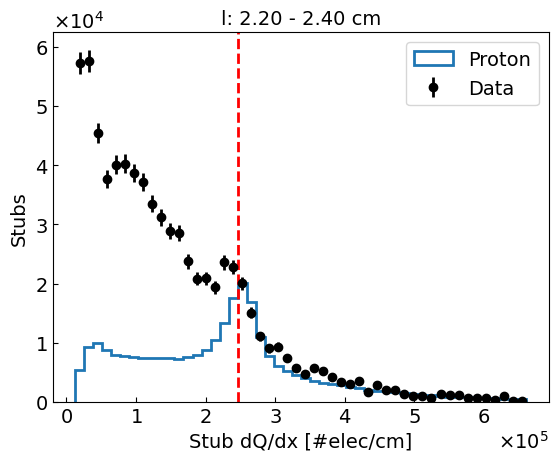

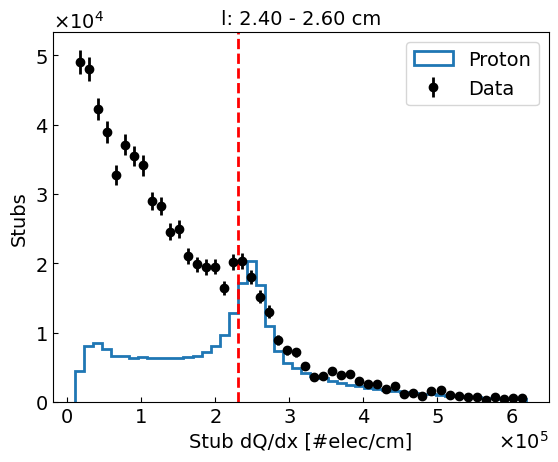

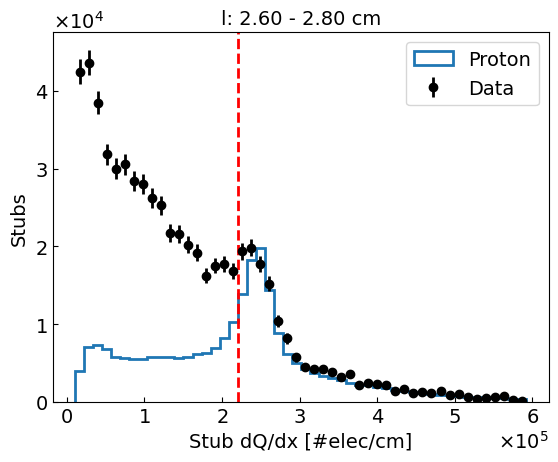

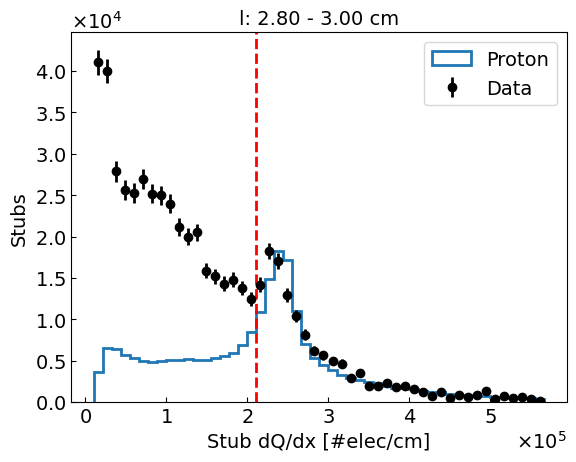

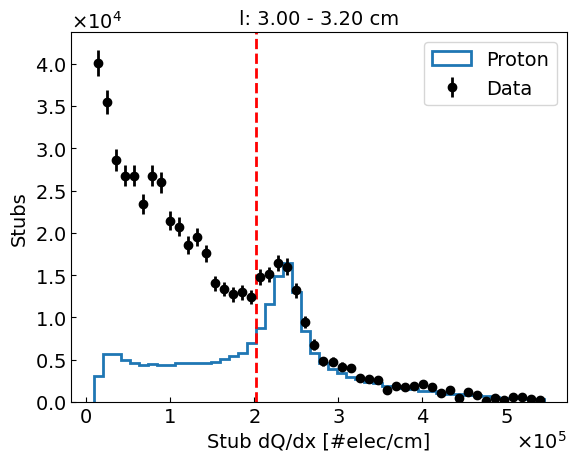

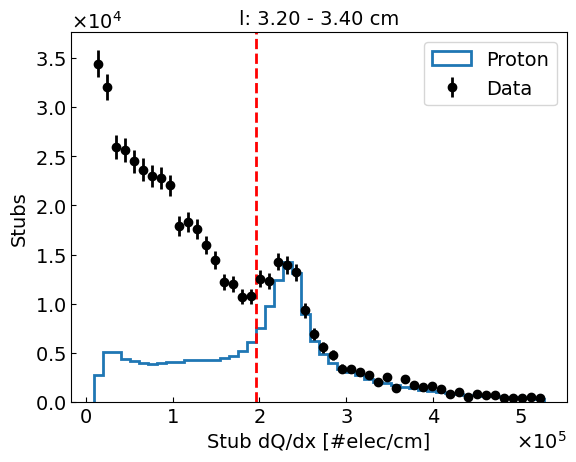

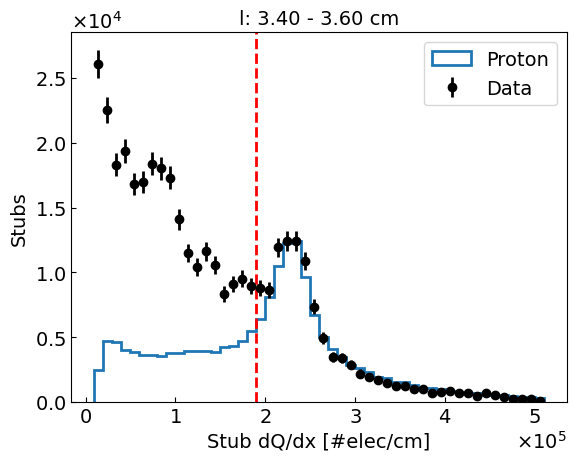

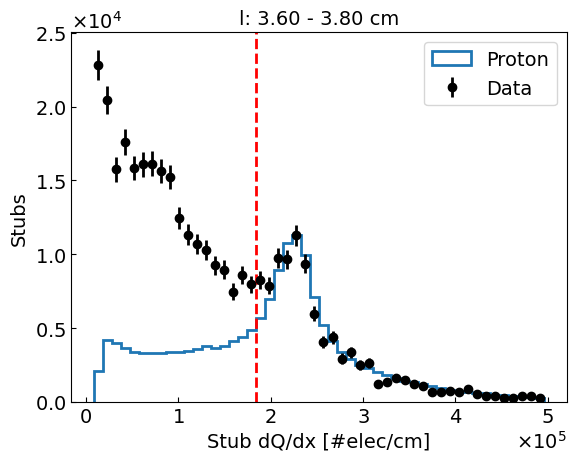

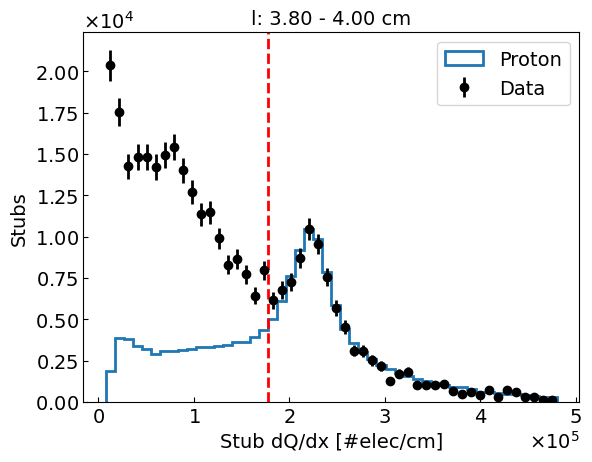

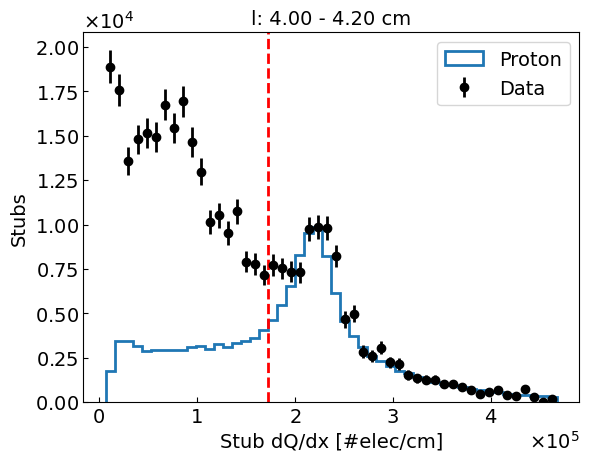

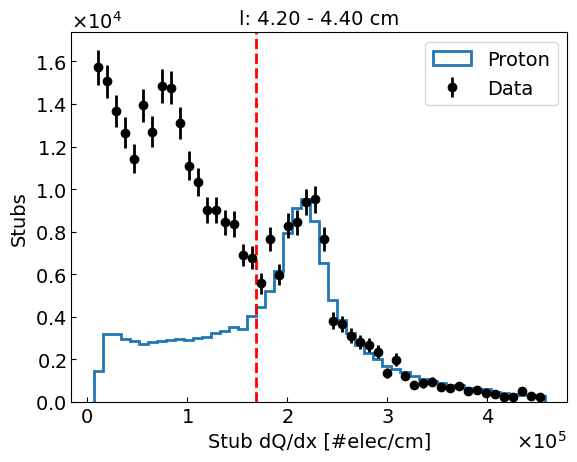

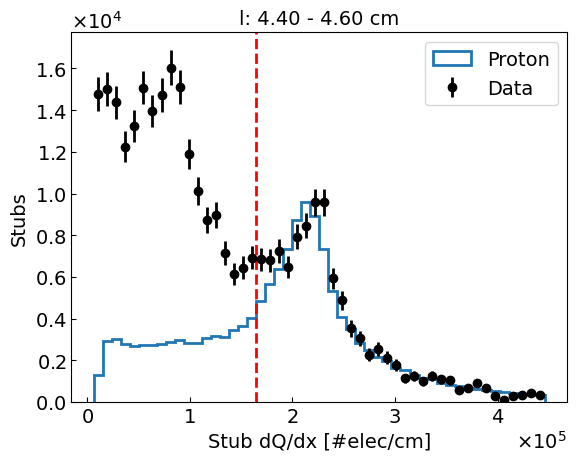

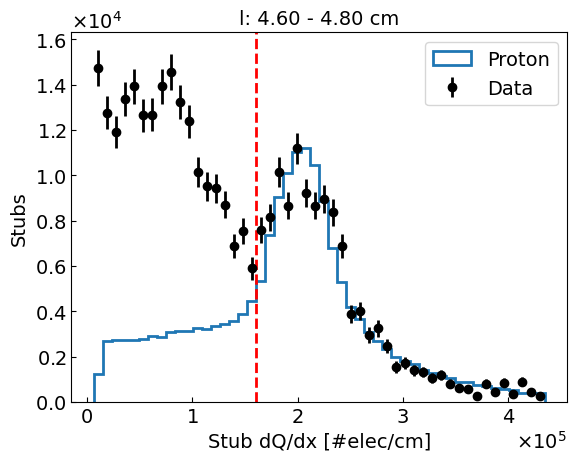

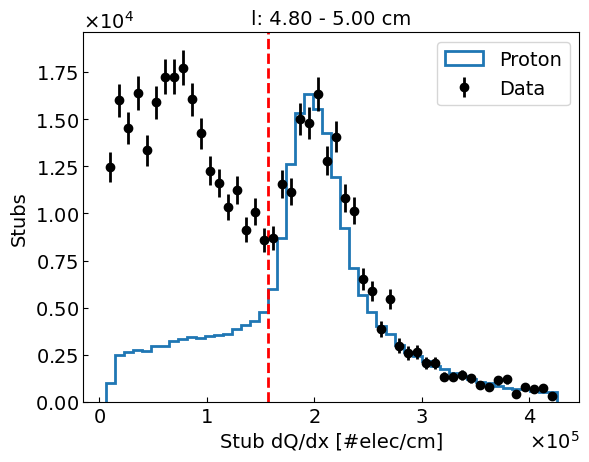

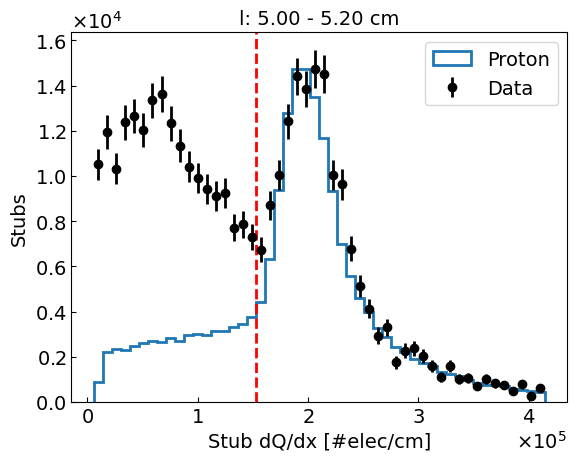

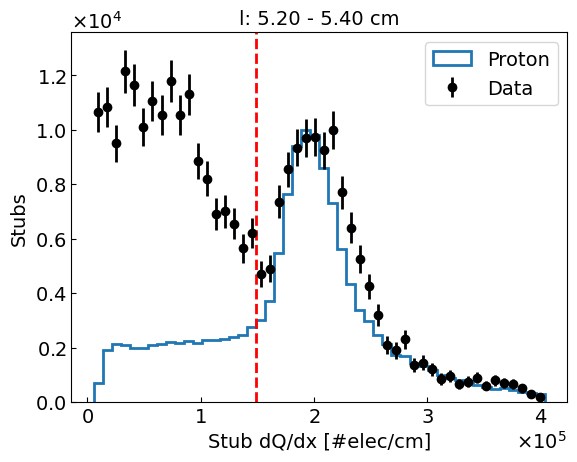

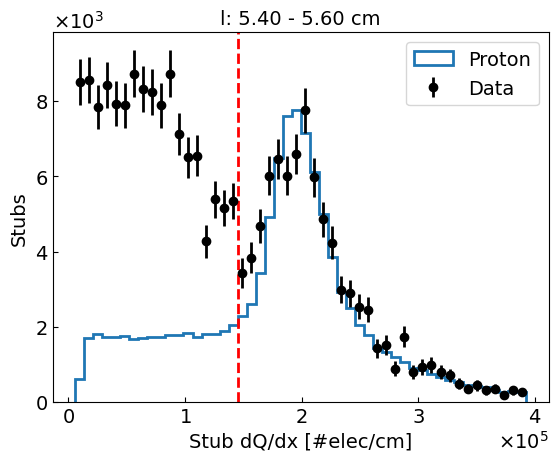

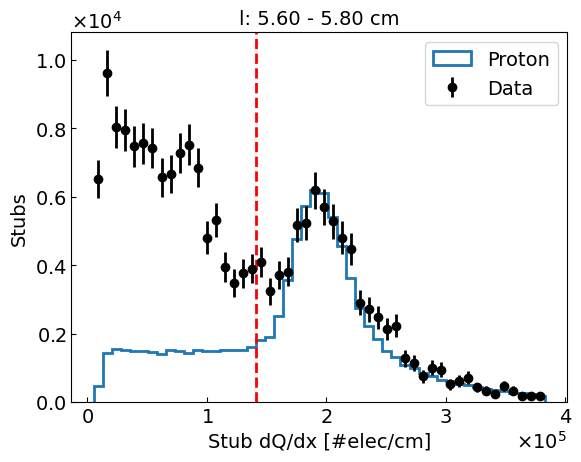

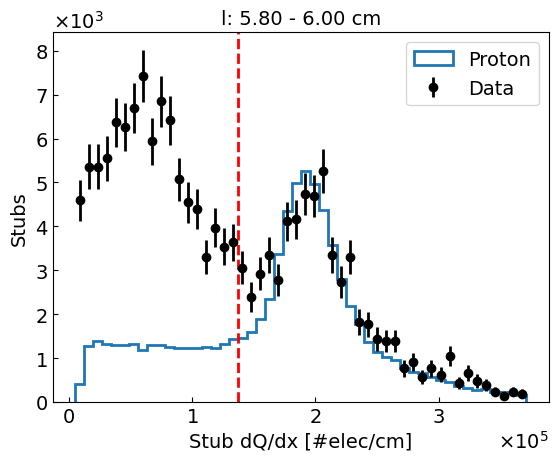

In [120]:
bins = np.linspace(2, 6, 21)
for i in range(20):
    plot_dqdx_1d(bins[i], bins[i+1])
